In [ ]:
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
class GradientBoostingRegressor(BaseEstimator):
    
    @staticmethod
    def mse_grad(y_true, y_pred):
        return y_true - y_pred
    
    @staticmethod
    def poisson_grad(y_true, y_pred):
        return np.exp(y_pred) - y_true
    
    @staticmethod
    def mse(y_true, y_pred):
        return mean_squared_error(y_true, y_pred)
    
    def __init__(self, n_estimators=10, learning_rate=0.01, loss='mse', 
                 max_depth=3, random_state=17):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.loss_name = loss
        self.max_depth = max_depth
        self.random_state = random_state
        self.y = 0    
        self.pred = 0
        self.residuals_ = []
        self.trees_ = []
        self.loss_ = []
            
    def fit(self, X, y):
        if self.loss_name == 'mse':
            self.y = y.mean()
        elif self.loss_name == 'poisson':
            self.y = np.log(y.mean())

        self.pred_fit = self.y
        for i in range(self.n_estimators - 1):
            if self.loss_name == 'mse':
                self.residuals_.append(self.mse_grad(y, self.pred_fit))
            elif self.loss_name == 'poisson':
                self.residuals_.append(-self.poisson_grad(y, self.pred_fit))

            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X, self.residuals_[-1])
            self.trees_.append(tree)

            self.pred_fit += self.learning_rate * self.trees_[-1].predict(X)

        return self
        
    def predict(self, X):
        self.pred = self.y
        for i in self.trees_:
            self.pred += self.learning_rate * i.predict(X)
        if self.loss_name == 'mse':
            return self.pred
        elif self.loss_name == 'poisson':
            return np.exp(self.pred)

In [ ]:
X = np.random.uniform(-4*np.pi, 4*np.pi, size=20000).reshape(-1, 1)

f = lambda t: 2*(1 - np.abs(t)/(4*np.pi))*np.abs(np.cos(t))

lam = np.exp(f(X)).flatten()
y = np.random.poisson(lam=lam)

In [ ]:
gbm_mse = GradientBoostingRegressor(learning_rate=0.01, loss='mse', n_estimators=1000)
gbm_poi = GradientBoostingRegressor(learning_rate=0.01, loss='poisson', n_estimators=1000)

gbm_mse.fit(X, y)
gbm_poi.fit(X, y)

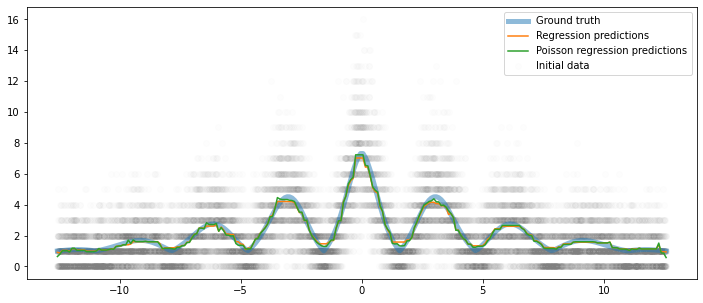

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(X.flatten(), y, color='grey', alpha=0.01, label='Initial data')

t = np.linspace(-4*np.pi, 4*np.pi, num=250)
ax.plot(t, np.exp(f(t)), label='Ground truth', linewidth=5, alpha=0.5)

yhat_mse = gbm_mse.predict(t.reshape(-1, 1))
ax.plot(t, yhat_mse, label='Regression predictions')

yhat_poi = gbm_poi.predict(t.reshape(-1, 1))
ax.plot(t, yhat_poi, label='Poisson regression predictions')

ax.legend()
plt.show()